# Contrastive Learning

### Data preparation

Installing the necessary libraries

In [ ]:
%%capture
!pip install torch torchvision

Importing the necessary libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

Different data transformations and loading the dataset

In [ ]:
%%capture
# Set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Usual transformations
transform_load = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def get_transformed_augmented(val):
    if val < 0.5:
        return transforms.Compose([
        transforms.RandomResizedCrop(size=224 ,scale=(0.7, 1.0), ratio=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(0.3),
    ])
    return transforms.Compose([
        transforms.RandomHorizontalFlip(0.3),
        transforms.ColorJitter(brightness=0.1, contrast=0.1,
                                  saturation=0.1, hue=0.05)
    ])

# Get the subset dataset and calculate the mean and std
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_load)
train_size = 1000
subset_indices = np.random.choice(len(train_dataset), train_size, replace=False)
subset_dataset = torch.utils.data.Subset(train_dataset, subset_indices)

val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_load)

Functions to get the normalization parameters

In [ ]:
# Data augmentation
def get_transforms(means, stds):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ])
    return transform

# Calculate the mean and std of the subset dataset
def get_mean_std(dataset):
    """Compute the mean and std value of dataset."""
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:, i, :, :].mean()
            std[i] += inputs[:, i, :, :].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

Obtaining the mean and std of the subset of the dataset

In [ ]:
# Calculate the mean and std of the subset dataset
train_means, train_stds = get_mean_std(subset_dataset)
print(f'Means: {train_means}')
print(f'Standard deviations: {train_stds}\n')
val_means, val_stds = get_mean_std(val_dataset)
print(f'Validation means: {val_means}')
print(f'Validation standard deviations: {val_stds}')

==> Computing mean and std..
Means: tensor([0.4866, 0.4753, 0.4391])
Standard deviations: tensor([0.1939, 0.1924, 0.1938])

==> Computing mean and std..
Validation means: tensor([0.4942, 0.4851, 0.4504])
Validation standard deviations: tensor([0.1949, 0.1922, 0.1944])


Applying transformations and loading in a dataloader

In [ ]:
%%capture
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=get_transforms(train_means,train_stds))
train_size = 5000
subset_indices = np.random.choice(len(train_dataset), train_size, replace=False)
subset_dataset = torch.utils.data.Subset(train_dataset, subset_indices)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=get_transforms(val_means,val_stds))

# Data Loader
train_loader = DataLoader(subset_dataset, batch_size=10, shuffle=True, num_workers=2)

Plotting 10 random images from the dataset (not transformed/then transformed)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


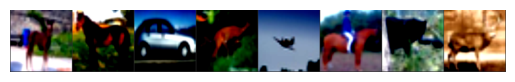

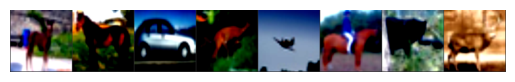

In [ ]:
def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    # Rescale pixel values to the range [0, 1]
    npimg = npimg*train_means.numpy() + train_stds.numpy()
    plt.imshow(npimg)
    plt.axis('off')
    plt.show()

# Get a batch of images
dataiter = iter(train_loader)

# Display 10 first images with Transformations
images, labels = next(dataiter)
transformation = get_transformed_augmented(np.random.rand())
selected_images_transformed = transformation(images[:8])
imshow(torchvision.utils.make_grid(images[:8]))
imshow(torchvision.utils.make_grid(selected_images_transformed))

## Contrastive Model

Import necessary libraries

In [ ]:
import torch.nn as nn
from torch.nn.functional import cosine_similarity
import torchvision.transforms.functional as TF
import torch.optim as optim
from tqdm import tqdm

Define the contrastive loss

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2, z_list):
        # Calculate cosine similarity
        similarity_pair = cosine_similarity(z1, z2, dim=-1) / self.temperature

        # Calculate the cosine similarity for each pair of z1 and... but not z1 and z1
        similarities = torch.stack([cosine_similarity(z1, rep, dim=-1) / self.temperature for rep in z_list if not torch.equal(rep, z1)])

        # Numerator is exp(similarity_pair)
        exp_similarity = torch.exp(similarity_pair)

        # Denominator is sum(exp(list_similarity_pair))
        exp_similarities = torch.sum(torch.exp(similarities))

        # Apply log-sum-exp trick for numerical stability
        loss = -torch.log(exp_similarity / (exp_similarities + exp_similarity))

        return loss

Define the Siamese network

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, base_model):
        super(SiameseNetwork, self).__init__()
        self.base_model = base_model
        self.linear1 = nn.Linear(512, 1024)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(1024, 512)


    def forward(self, x1, x2):
        z1 = self.base_model(x1)
        z1 = self.relu1(self.linear1(z1.view(z1.size(0), -1)))
        z1 = self.linear2(z1)
        z2 = self.base_model(x2)
        z2 = self.relu1(self.linear1(z2.view(z2.size(0), -1)))
        z2 = self.linear2(z2)
        return z1, z2

Define the ResNet18-based model

In [ ]:
class SimpleResNet(nn.Module):
    def __init__(self):
        super(SimpleResNet, self).__init__()
        self.resnet = torchvision.models.resnet18()
        self.resnet = nn.Sequential(*(list(self.resnet.children())[:-1]))

    def forward(self, x):
        return self.resnet(x)

## Initialization

Initialize the model, optimizer, and contrastive loss

In [ ]:
model = SiameseNetwork(SimpleResNet())
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = ContrastiveLoss()

Training parameters

In [ ]:
%%capture
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

## Traning loop

In [ ]:
loss_history = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for i, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')):

        images, _ = data
        images = images.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Initialize total loss for the batch
        batch_loss = torch.tensor(0.0, device=device, requires_grad=True)

        # Create tuples of transformed images for each image of the batch and put all the zk, zk+1 in a list (feed forward network)
        zk_list = []
        for image in images:
            transformation1 = get_transformed_augmented(np.random.rand())
            transformation2 = get_transformed_augmented(np.random.rand())
            transformed_image1 = transformation1(image).to(device)
            transformed_image2 = transformation2(image).to(device)

            z1, z2 = model(transformed_image1.unsqueeze(0), transformed_image2.unsqueeze(0))
            zk_list.append(z1)
            zk_list.append(z2)


        # Process each image in the batch
        for i in range(0, len(zk_list), 2):
            # Calculate loss for both the first transformed image and second
            loss1 = criterion(zk_list[i], zk_list[i+1], zk_list)
            loss2 = criterion(zk_list[i+1], zk_list[i], zk_list)
            batch_loss = batch_loss + (loss1 + loss2)

        # Backward pass
        batch_loss.backward()

        # Update weights after processing the entire batch
        optimizer.step()

        total_loss += batch_loss.item() / 2*len(images)

    average_loss = total_loss / len(train_loader)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}')
    loss_history.append(average_loss)

print('Training finished.')

Epoch 1/20: 100%|██████████| 500/500 [03:54<00:00,  2.14it/s]


Epoch 1/20, Loss: 108.55336681365966


Epoch 2/20: 100%|██████████| 500/500 [03:48<00:00,  2.19it/s]


Epoch 2/20, Loss: 80.68030944824218


Epoch 3/20: 100%|██████████| 500/500 [03:43<00:00,  2.24it/s]


Epoch 3/20, Loss: 77.12458863258362


Epoch 4/20: 100%|██████████| 500/500 [03:42<00:00,  2.25it/s]


Epoch 4/20, Loss: 76.96965435028076


Epoch 5/20: 100%|██████████| 500/500 [03:48<00:00,  2.19it/s]


Epoch 5/20, Loss: 76.1170642375946


Epoch 6/20: 100%|██████████| 500/500 [03:43<00:00,  2.24it/s]


Epoch 6/20, Loss: 75.3515521621704


Epoch 7/20: 100%|██████████| 500/500 [03:40<00:00,  2.27it/s]


Epoch 7/20, Loss: 75.71119214057923


Epoch 8/20: 100%|██████████| 500/500 [03:43<00:00,  2.23it/s]


Epoch 8/20, Loss: 75.8081392288208


Epoch 9/20: 100%|██████████| 500/500 [03:40<00:00,  2.27it/s]


Epoch 9/20, Loss: 74.10402077674865


Epoch 10/20: 100%|██████████| 500/500 [03:42<00:00,  2.25it/s]


Epoch 10/20, Loss: 73.67078850746155


Epoch 11/20: 100%|██████████| 500/500 [03:40<00:00,  2.27it/s]


Epoch 11/20, Loss: 73.52470023155212


Epoch 12/20: 100%|██████████| 500/500 [03:40<00:00,  2.27it/s]


Epoch 12/20, Loss: 73.17311614036561


Epoch 13/20: 100%|██████████| 500/500 [03:43<00:00,  2.23it/s]


Epoch 13/20, Loss: 73.07581250190735


Epoch 14/20: 100%|██████████| 500/500 [03:39<00:00,  2.28it/s]


Epoch 14/20, Loss: 73.44656658172607


Epoch 15/20: 100%|██████████| 500/500 [03:38<00:00,  2.29it/s]


Epoch 15/20, Loss: 72.4629507637024


Epoch 16/20: 100%|██████████| 500/500 [03:38<00:00,  2.29it/s]


Epoch 16/20, Loss: 72.91371952056885


Epoch 17/20: 100%|██████████| 500/500 [03:38<00:00,  2.29it/s]


Epoch 17/20, Loss: 73.00588367462159


Epoch 18/20: 100%|██████████| 500/500 [03:39<00:00,  2.28it/s]


Epoch 18/20, Loss: 71.9663871383667


Epoch 19/20: 100%|██████████| 500/500 [03:36<00:00,  2.31it/s]


Epoch 19/20, Loss: 72.0968148612976


Epoch 20/20: 100%|██████████| 500/500 [03:37<00:00,  2.30it/s]

Epoch 20/20, Loss: 72.30563623428344
Training finished.


Plot the loss history

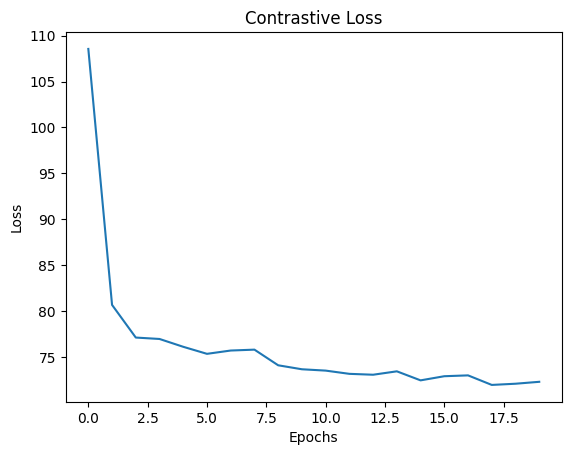

In [ ]:
plt.plot(loss_history)
plt.title('Contrastive Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Save the trained model

In [ ]:
torch.save(model.base_model.state_dict(), 'model_clr.pth')

## Learned representations

### TSNE (t-distributed Stochastic Neighbor Embedding)

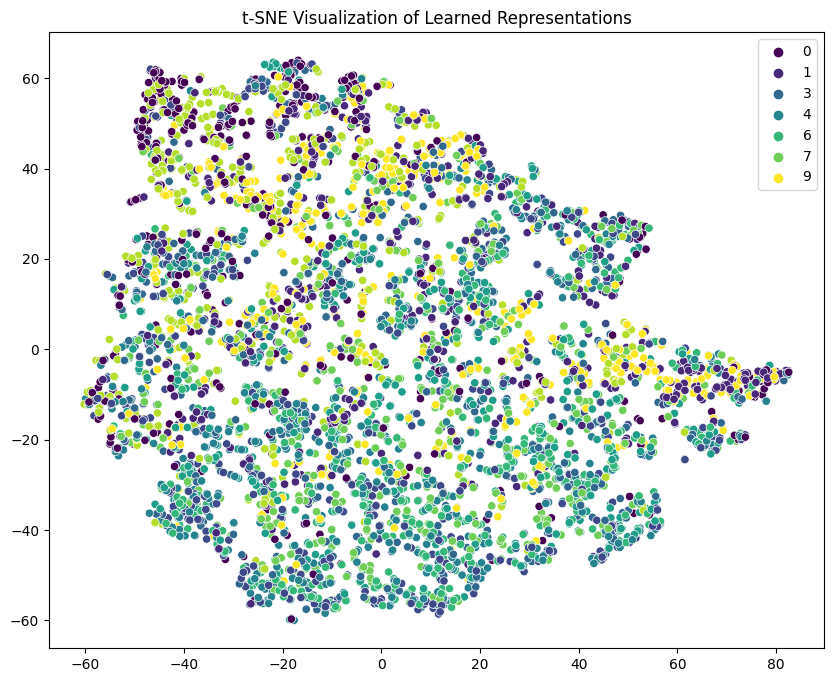

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns


num_visualization_samples = 100
visualization_loader = DataLoader(subset_dataset, batch_size=num_visualization_samples, shuffle=True, num_workers=2)

model.eval()
all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in visualization_loader:
        images = images.to(device)
        features = model.base_model(images)
        all_features.append(features.cpu().numpy())
        all_labels.append(labels.numpy())

all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
all_features_reshaped = all_features.reshape(all_features.shape[0], -1)
embedded_features = tsne.fit_transform(all_features_reshaped)

# Plot the t-SNE embeddings
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embedded_features[:, 0], y=embedded_features[:, 1], hue=all_labels, palette='viridis')
plt.title('t-SNE Visualization of Learned Representations')
plt.show()

### Nearest Neighbors Search

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


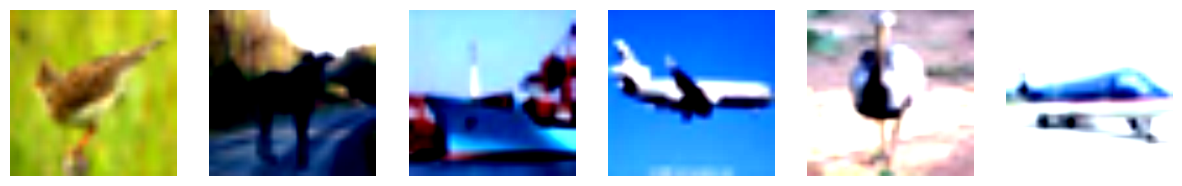

In [ ]:
from sklearn.neighbors import NearestNeighbors

num_neighbors_search_samples = 10
neighbors_search_loader = DataLoader(subset_dataset, batch_size=num_neighbors_search_samples, shuffle=True, num_workers=2)

model.eval()
all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in neighbors_search_loader:
        images = images.to(device)
        features = model.base_model(images)
        all_features.append(features.cpu().numpy())
        all_labels.append(labels.numpy())

all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Fit a nearest neighbors model
nn_model = NearestNeighbors(n_neighbors=5, metric='cosine')
nn_model.fit(all_features)

# Query for nearest neighbors for a random sample
query_index = np.random.choice(len(val_dataset))
query_image, query_label = val_dataset[query_index]
query_feature = model.base_model(query_image.unsqueeze(0).to(device)).cpu().detach().numpy().reshape(1, -1)
_, neighbors = nn_model.kneighbors(query_feature)

def visualize_images(images):
    """Visualize a list of images."""
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        axes[i].imshow(np.transpose(images[i]/2+0.5, (1, 2, 0)))
        axes[i].axis('off')

    plt.show()

# Visualize query and its nearest neighbors
visualize_images([query_image] + [val_dataset[i][0] for i in neighbors[0]])


## Classification Head


### Usual MLP

Clear the cache and empty the GPU memory if needed

In [ ]:
torch.cuda.empty_cache()

Define a simple MLP model

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define transformation to convert CIFAR-10 images to grayscale
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load CIFAR-10 dataset
train_dataset_mlp = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset_mlp = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define data loaders
batch_size = 128

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Calculate the mean and std of the subset dataset
train_means_mlp, train_stds_mlp = get_mean_std(train_dataset_mlp)
print(f'Means: {train_means_mlp}')
print(f'Standard deviations: {train_stds_mlp}\n')
val_means_mlp, val_stds_mlp = get_mean_std(test_dataset_mlp)
print(f'Validation means: {val_means_mlp}')
print(f'Validation standard deviations: {val_stds_mlp}')

==> Computing mean and std..
Means: tensor([0.4914, 0.4822, 0.4465])
Standard deviations: tensor([0.2023, 0.1994, 0.2010])

==> Computing mean and std..
Validation means: tensor([0.4942, 0.4851, 0.4504])
Validation standard deviations: tensor([0.2020, 0.1991, 0.2011])


Apply transformations

In [ ]:
%%capture
train_dataset_mlp = datasets.CIFAR10(root='./data', train=True, download=True, transform=get_transforms(train_means_mlp,train_stds_mlp))
val_dataset_mlp = datasets.CIFAR10(root='./data', train=False, download=True, transform=get_transforms(val_means_mlp,val_stds_mlp))

# Data Loader
train_loader_mlp = DataLoader(train_dataset_mlp, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader_mlp = DataLoader(val_dataset_mlp, batch_size=batch_size, shuffle=False, num_workers=2)

Define model, criterion, and optimizer

In [ ]:
input_size = 224 * 224 * 3  # Size of CIFAR-10 images after flattening
hidden_size = 256
output_size = 10  # Number of classes in CIFAR-10
mlp_model = MLP(input_size, hidden_size, output_size)
mlp_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

num_epochs = 10

Training loop

In [ ]:
for epoch in range(num_epochs):
    mlp_model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for i, data in enumerate(tqdm(train_loader_mlp, desc=f'Epoch {epoch + 1}/{num_epochs}')):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = mlp_model(images.view(images.size(0), -1))

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)

    average_loss = total_loss / len(train_loader)
    accuracy = correct / total_samples

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}, Accuracy: {accuracy}')

print('Training finished.')

Epoch 1/10: 100%|██████████| 391/391 [00:28<00:00, 13.59it/s]


Epoch 1/10, Loss: 5.452323257064819, Accuracy: 0.30684


Epoch 2/10: 100%|██████████| 391/391 [00:28<00:00, 13.81it/s]


Epoch 2/10, Loss: 1.0613502403259278, Accuracy: 0.39888


Epoch 3/10: 100%|██████████| 391/391 [00:28<00:00, 13.55it/s]


Epoch 3/10, Loss: 0.549143210220337, Accuracy: 0.45944


Epoch 4/10: 100%|██████████| 391/391 [00:29<00:00, 13.31it/s]


Epoch 4/10, Loss: 0.514160632801056, Accuracy: 0.47282


Epoch 5/10: 100%|██████████| 391/391 [00:28<00:00, 13.61it/s]


Epoch 5/10, Loss: 0.5345180750846863, Accuracy: 0.46676


Epoch 6/10: 100%|██████████| 391/391 [00:28<00:00, 13.60it/s]


Epoch 6/10, Loss: 0.5612415117263794, Accuracy: 0.45636


Epoch 7/10: 100%|██████████| 391/391 [00:29<00:00, 13.46it/s]


Epoch 7/10, Loss: 0.5988725337982178, Accuracy: 0.44372


Epoch 8/10: 100%|██████████| 391/391 [00:28<00:00, 13.49it/s]


Epoch 8/10, Loss: 0.6445986505508423, Accuracy: 0.4322


Epoch 9/10: 100%|██████████| 391/391 [00:28<00:00, 13.72it/s]


Epoch 9/10, Loss: 0.6812190964698791, Accuracy: 0.42154


Epoch 10/10: 100%|██████████| 391/391 [00:29<00:00, 13.25it/s]

Epoch 10/10, Loss: 0.7083056594848632, Accuracy: 0.42348
Training finished.


Evaluate on the test set

In [ ]:
mlp_model.eval()
correct = 0
total_samples = 0

with torch.no_grad():
    for data in tqdm(test_loader_mlp, desc='Testing'):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = mlp_model(images.view(images.size(0), -1))
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)

accuracy = correct / total_samples
print(f'Test Accuracy: {accuracy}')

Testing: 100%|██████████| 79/79 [00:06<00:00, 12.85it/s]

Test Accuracy: 0.3875


Save the MLP model weights

In [ ]:
torch.save(mlp_model.state_dict(), 'model_mlp.pth')

#### Our SimCLR model with MLP Head

In [ ]:
clr_base_model = SimpleResNet()
clr_base_model.load_state_dict(torch.load('model_clr.pth'))
clr_base_model.eval()

SimpleResNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

Define the MLP head for classification

In [ ]:
class MLPHead(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPHead, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the full model with contrastive feature extractor and MLP head
class ContrastiveMLPModel(nn.Module):
    def __init__(self, feature_extractor, mlp_head):
        super(ContrastiveMLPModel, self).__init__()
        self.base_model = feature_extractor
        self.mlp_model = mlp_head

    def forward(self, x):
        features = self.base_model(x)
        return self.mlp_model(features.view(features.size(0), -1))

Parameters, model, optimizer, and loss function

In [ ]:
# Output size of base model: torch.Size([1, 512])
input_size_for_mlp = 512

# Define the MLP head for classification
mlp_head = MLPHead(input_size_for_mlp, hidden_size=256, num_classes=output_size)

# Combine the feature extractor and MLP head into the full model
contrastive_mlp_model = ContrastiveMLPModel(clr_base_model, mlp_head)
contrastive_mlp_model.base_model.requires_grad = False

# Define the optimizer
mlp_lr = 0.001
optimizer = torch.optim.Adam(contrastive_mlp_model.mlp_model.parameters(), lr=mlp_lr)
criterion = nn.CrossEntropyLoss()

# Define the training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
contrastive_mlp_model.to(device)

ContrastiveMLPModel(
  (base_model): SimpleResNet(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchN

Training loop

In [ ]:
for epoch in range(num_epochs):
    contrastive_mlp_model.train()
    total_classification_loss = 0

    for i, data in enumerate(tqdm(train_loader_mlp, desc=f'Epoch {epoch + 1}/{num_epochs}')):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients only for the parameters that require grad (MLP head)
        contrastive_mlp_model.zero_grad()

        # Forward pass
        predictions = contrastive_mlp_model(images)

        # Calculate classification loss using CrossEntropyLoss
        classification_loss = criterion(predictions, labels)
        total_classification_loss += classification_loss.item()


        # Backward pass and update weights for the MLP head only
        classification_loss.backward()
        optimizer.step()

    average_classification_loss = total_classification_loss / len(train_loader)

    print(f'Epoch {epoch + 1}/{num_epochs}, Classification Loss: {average_classification_loss}')

print('Training finished.')

Epoch 1/10: 100%|██████████| 391/391 [02:25<00:00,  2.68it/s]


Epoch 1/10, Classification Loss: 1.4270019285678863


Epoch 2/10: 100%|██████████| 391/391 [02:26<00:00,  2.68it/s]


Epoch 2/10, Classification Loss: 1.3041980919837952


Epoch 3/10: 100%|██████████| 391/391 [02:25<00:00,  2.69it/s]


Epoch 3/10, Classification Loss: 1.266168580532074


Epoch 4/10: 100%|██████████| 391/391 [02:25<00:00,  2.69it/s]


Epoch 4/10, Classification Loss: 1.2387057392597198


Epoch 5/10: 100%|██████████| 391/391 [02:25<00:00,  2.69it/s]


Epoch 5/10, Classification Loss: 1.216098400592804


Epoch 6/10: 100%|██████████| 391/391 [02:25<00:00,  2.68it/s]


Epoch 6/10, Classification Loss: 1.1984258534908294


Epoch 7/10: 100%|██████████| 391/391 [02:25<00:00,  2.69it/s]


Epoch 7/10, Classification Loss: 1.1862416291236877


Epoch 8/10: 100%|██████████| 391/391 [02:25<00:00,  2.69it/s]


Epoch 8/10, Classification Loss: 1.169883648633957


Epoch 9/10: 100%|██████████| 391/391 [02:25<00:00,  2.69it/s]


Epoch 9/10, Classification Loss: 1.1605588829517364


Epoch 10/10: 100%|██████████| 391/391 [02:26<00:00,  2.67it/s]

Epoch 10/10, Classification Loss: 1.149979236125946
Training finished.


Evaluate on the test set

In [ ]:
contrastive_mlp_model.eval()
correct = 0
total_samples = 0

with torch.no_grad():
    for data in tqdm(test_loader_mlp, desc='Testing'):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = contrastive_mlp_model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)

accuracy = correct / total_samples
print(f'Test Accuracy: {accuracy}')

Testing: 100%|██████████| 79/79 [00:19<00:00,  4.14it/s]

Test Accuracy: 0.4699


### Using a more complex architecture of FC layers

Defining the Architecture of the neural network

In [ ]:
class ComplexFC(nn.Module):
    def __init__(self, input_channels=3, input_size=(224, 224), num_classes=10):
        super(ComplexFC, self).__init__()
        self.input_channels = input_channels
        self.input_size = input_size
        self.fc1 = nn.Linear(input_channels * input_size[0] * input_size[1], 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input assuming it's of shape [batch_size, input_channels, height, width]
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Transformations and Dataset

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define transformation to convert CIFAR-10 images to grayscale
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load CIFAR-10 dataset
train_dataset_fc = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset_fc = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define data loaders
batch_size = 64

Files already downloaded and verified
Files already downloaded and verified


Calculating means and stds

In [ ]:
# Calculate the mean and std of the subset dataset
train_means_fc, train_stds_fc = get_mean_std(train_dataset_fc)
print(f'Means: {train_means_fc}')
print(f'Standard deviations: {train_stds_fc}\n')
val_means_fc, val_stds_fc = get_mean_std(test_dataset_fc)
print(f'Validation means: {val_means_fc}')
print(f'Validation standard deviations: {val_stds_fc}')

==> Computing mean and std..
Means: tensor([0.4914, 0.4822, 0.4465])
Standard deviations: tensor([0.2023, 0.1994, 0.2010])

==> Computing mean and std..
Validation means: tensor([0.4942, 0.4851, 0.4504])
Validation standard deviations: tensor([0.2020, 0.1991, 0.2011])


Applying transformations

In [ ]:
%%capture
# Apply transformations
train_dataset_fc = datasets.CIFAR10(root='./data', train=True, download=True, transform=get_transforms(train_means_fc,train_stds_fc))
val_dataset_fc = datasets.CIFAR10(root='./data', train=False, download=True, transform=get_transforms(val_means_fc,val_stds_fc))

# Data Loader
train_loader_fc = DataLoader(train_dataset_fc, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader_fc = DataLoader(val_dataset_fc, batch_size=batch_size, shuffle=False, num_workers=2)

Defining the model, optimizer, and loss function

In [ ]:
# Define model, criterion, and optimizer
num_classes = 10  # Number of classes in CIFAR-10
fc_model = ComplexFC(input_channels=3, input_size=(224, 224), num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fc_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fc_model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

Traning loop

In [ ]:
for epoch in range(num_epochs):
    fc_model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for i, data in enumerate(tqdm(train_loader_fc, desc=f'Epoch {epoch + 1}/{num_epochs}')):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = fc_model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)

    average_loss = total_loss / len(train_loader_fc)
    accuracy = correct / total_samples

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}, Accuracy: {accuracy}')

print('Training finished.')

Epoch 1/10: 100%|██████████| 782/782 [00:29<00:00, 26.34it/s]


Epoch 1/10, Loss: 1.7963390856447732, Accuracy: 0.36648


Epoch 2/10: 100%|██████████| 782/782 [00:29<00:00, 26.89it/s]


Epoch 2/10, Loss: 1.6391650677641945, Accuracy: 0.41988


Epoch 3/10: 100%|██████████| 782/782 [00:29<00:00, 26.54it/s]


Epoch 3/10, Loss: 1.5780685742187988, Accuracy: 0.4431


Epoch 4/10: 100%|██████████| 782/782 [00:29<00:00, 26.82it/s]


Epoch 4/10, Loss: 1.531396267359214, Accuracy: 0.46244


Epoch 5/10: 100%|██████████| 782/782 [00:29<00:00, 26.82it/s]


Epoch 5/10, Loss: 1.5044375595534245, Accuracy: 0.4735


Epoch 6/10: 100%|██████████| 782/782 [00:29<00:00, 26.66it/s]


Epoch 6/10, Loss: 1.4774681383081714, Accuracy: 0.48122


Epoch 7/10: 100%|██████████| 782/782 [00:29<00:00, 26.75it/s]


Epoch 7/10, Loss: 1.4611272255478003, Accuracy: 0.48808


Epoch 8/10: 100%|██████████| 782/782 [00:29<00:00, 26.83it/s]


Epoch 8/10, Loss: 1.4331544579752267, Accuracy: 0.49766


Epoch 9/10: 100%|██████████| 782/782 [00:29<00:00, 26.68it/s]


Epoch 9/10, Loss: 1.4167540324923327, Accuracy: 0.5032


Epoch 10/10: 100%|██████████| 782/782 [00:29<00:00, 26.38it/s]

Epoch 10/10, Loss: 1.4012743357349844, Accuracy: 0.5107
Training finished.


Evaluating on the test set

In [ ]:
# Evaluate on the test set
fc_model.eval()
correct = 0
total_samples = 0

with torch.no_grad():
    for data in tqdm(test_loader_fc, desc='Testing'):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = fc_model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)

accuracy = correct / total_samples
print(f'Test Accuracy: {accuracy}')

Testing: 100%|██████████| 157/157 [00:06<00:00, 26.00it/s]

Test Accuracy: 0.53


In [ ]:
torch.save(fc_model.state_dict(), 'model_fc.pth')

#### Our SimCLR model with CNN Head

Loading the SimCLR model

In [ ]:
clr_base_model_for_fc = SimpleResNet()
clr_base_model_for_fc.load_state_dict(torch.load('model_clr_100_epochs.pth'))
clr_base_model_for_fc.eval()

SimpleResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Defining the CNN Head

In [ ]:
class FCHead(nn.Module):
    def __init__(self, input_size=512, num_classes=10):
        super(FCHead, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(self.input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class ContrastiveFCModel(nn.Module):
    def __init__(self, feature_extractor, fc_head):
        super(ContrastiveFCModel, self).__init__()
        self.base_model = feature_extractor
        self.fc_model = fc_head

    def forward(self, x):
        features = self.base_model(x)
        return self.fc_model(features.view(features.size(0), -1))

Parameters, model, optimizer, and loss function

In [ ]:
# Define the CNN head for classification
fc_head = FCHead(input_size=512, num_classes=num_classes)

# Combine the feature extractor and MLP head into the full model
contrastive_fc_model = ContrastiveFCModel(clr_base_model_for_fc, fc_head)
contrastive_fc_model.base_model.requires_grad = False

# Define the optimizer
mlp_lr = 0.001
optimizer = torch.optim.Adam(contrastive_fc_model.fc_model.parameters(), lr=mlp_lr)
criterion = nn.CrossEntropyLoss()

# Define the training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
contrastive_fc_model.to(device)

ContrastiveFCModel(
  (base_model): SimpleResNet(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

In [ ]:
# Training loop
for epoch in range(num_epochs):
    contrastive_fc_model.train()
    total_classification_loss = 0

    for i, data in enumerate(tqdm(train_loader_fc, desc=f'Epoch {epoch + 1}/{num_epochs}')):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients only for the parameters that require grad (FC head)
        contrastive_fc_model.zero_grad()

        # Forward pass
        predictions = contrastive_fc_model(images)

        # Calculate classification loss using CrossEntropyLoss
        classification_loss = criterion(predictions, labels)
        total_classification_loss += classification_loss.item()

        # Backward pass and update weights for the FC head only
        classification_loss.backward()
        optimizer.step()

    average_classification_loss = total_classification_loss / len(train_loader)

    print(f'Epoch {epoch + 1}/{num_epochs}, Classification Loss: {average_classification_loss}')

print('Training finished.')

Epoch 1/10: 100%|██████████| 782/782 [01:33<00:00,  8.35it/s]


Epoch 1/10, Classification Loss: 1.0577284106254579


Epoch 2/10: 100%|██████████| 782/782 [01:34<00:00,  8.31it/s]


Epoch 2/10, Classification Loss: 1.0021654881477355


Epoch 3/10: 100%|██████████| 782/782 [01:33<00:00,  8.32it/s]


Epoch 3/10, Classification Loss: 0.9813038632392883


Epoch 4/10: 100%|██████████| 782/782 [01:34<00:00,  8.26it/s]


Epoch 4/10, Classification Loss: 0.97359410572052


Epoch 5/10: 100%|██████████| 782/782 [01:34<00:00,  8.26it/s]


Epoch 5/10, Classification Loss: 0.9641896392822266


Epoch 6/10: 100%|██████████| 782/782 [01:34<00:00,  8.29it/s]


Epoch 6/10, Classification Loss: 0.9577692916870117


Epoch 7/10: 100%|██████████| 782/782 [01:33<00:00,  8.33it/s]


Epoch 7/10, Classification Loss: 0.9540761549949646


Epoch 8/10: 100%|██████████| 782/782 [01:33<00:00,  8.36it/s]


Epoch 8/10, Classification Loss: 0.9469254410743714


Epoch 9/10: 100%|██████████| 782/782 [01:33<00:00,  8.36it/s]


Epoch 9/10, Classification Loss: 0.942102390384674


Epoch 10/10: 100%|██████████| 782/782 [01:33<00:00,  8.36it/s]

Epoch 10/10, Classification Loss: 0.9394916420936584
Training finished.


Evaluating on the test set

In [ ]:
# Evaluate on the test set
contrastive_fc_model.eval()
correct = 0
total_samples = 0

with torch.no_grad():
    for data in tqdm(test_loader_fc, desc='Testing'):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = contrastive_fc_model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)

accuracy = correct / total_samples
print(f'Test Accuracy: {accuracy}')

Testing: 100%|██████████| 157/157 [00:07<00:00, 20.24it/s]

Test Accuracy: 0.4794


## Plot the results

### Accuracy

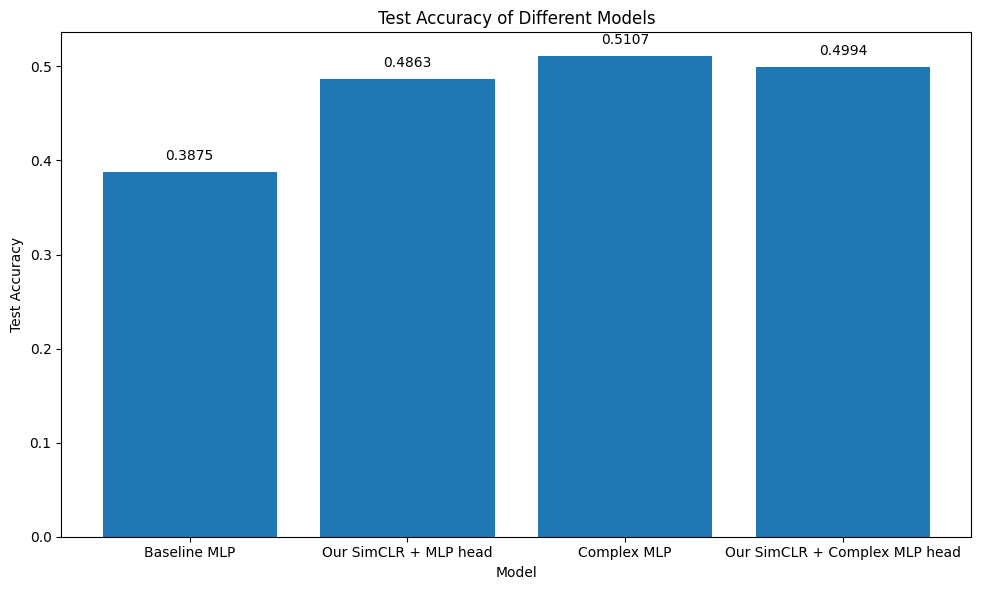

In [ ]:
import matplotlib.pyplot as plt

# Define the model names and their corresponding test accuracies
models = ['Baseline MLP', 'Our SimCLR + MLP head', 'Complex MLP', 'Our SimCLR + Complex MLP head']
accuracies = [0.3875, 0.4863, 0.5107, 0.4994]

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies)

# Adding the title and labels
plt.title('Test Accuracy of Different Models')
plt.ylabel('Test Accuracy')
plt.xlabel('Model')

# Displaying the values on the bars
for i in range(len(accuracies)):
    plt.text(i, accuracies[i] + 0.01, f'{accuracies[i]:.4f}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


### PCA analysis on the input images

In [ ]:
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

X, y = fetch_openml('cifar_10_small', version=1, return_X_y=True)

y_numeric = y.astype(int)


In [ ]:
import pandas as pd
# Convert to DataFrame for easier manipulation
df = pd.DataFrame(X)
df['label'] = y

# Sample 100 instances per class
sampled_df = df.groupby('label').apply(lambda x: x.sample(n=100)).reset_index(drop=True)
X_sampled = sampled_df.drop('label', axis=1)
y_sampled = sampled_df['label'].astype(int)

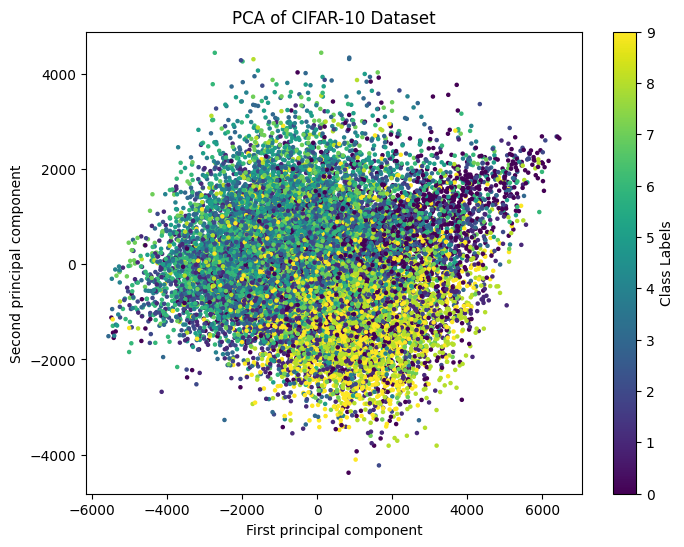

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_numeric, cmap='viridis', s=5)
plt.title("PCA of CIFAR-10 Dataset")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.colorbar(scatter, label='Class Labels')
plt.show()

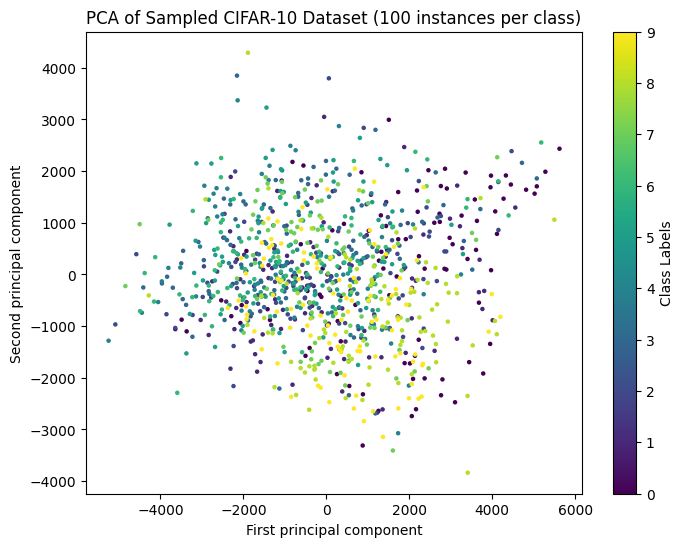

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sampled)

# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_sampled, cmap='viridis', s=5)
plt.title("PCA of Sampled CIFAR-10 Dataset (100 instances per class)")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.colorbar(scatter, label='Class Labels')
plt.show()


### T-sne of the input images

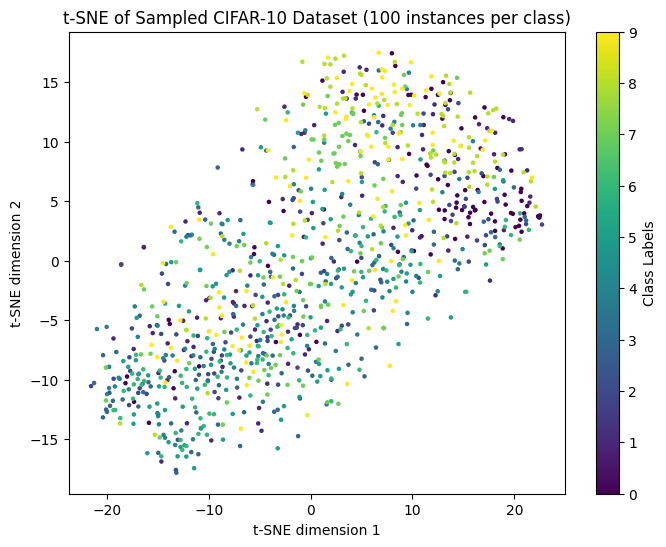

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_sampled)

# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sampled, cmap='viridis', s=5)
plt.title("t-SNE of Sampled CIFAR-10 Dataset (100 instances per class)")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.colorbar(scatter, label='Class Labels')
plt.show()